In [ ]:
# 1. Mount Drive (if you haven't already)
from google.colab import drive
drive.mount('/content/gdrive')

# 2. Define the path to your zipped dataset in Google Drive
ZIP_PATH = '/content/gdrive/MyDrive/tiget.zip'

# 3. Unzip the file into the current working directory (/content/)
# The -q flag is for quiet (less output), -d . extracts to the current directory
!unzip -q "{ZIP_PATH}" -d .

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Loading and preprocessing all data...
Total images loaded: 304
Train images split: 243, Validation images split: 61
Starting CAE training...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 762ms/step - loss: 0.2190 - val_loss: 0.1296
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0983 - val_loss: 0.0491
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0418 - val_loss: 0.0261
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0238 - val_loss: 0.0159
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0164 - val_loss: 0.0176
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0141 - val_loss: 0.0104
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0098 - val_loss: 0.0081
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0081 - val_loss: 0.0072
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 

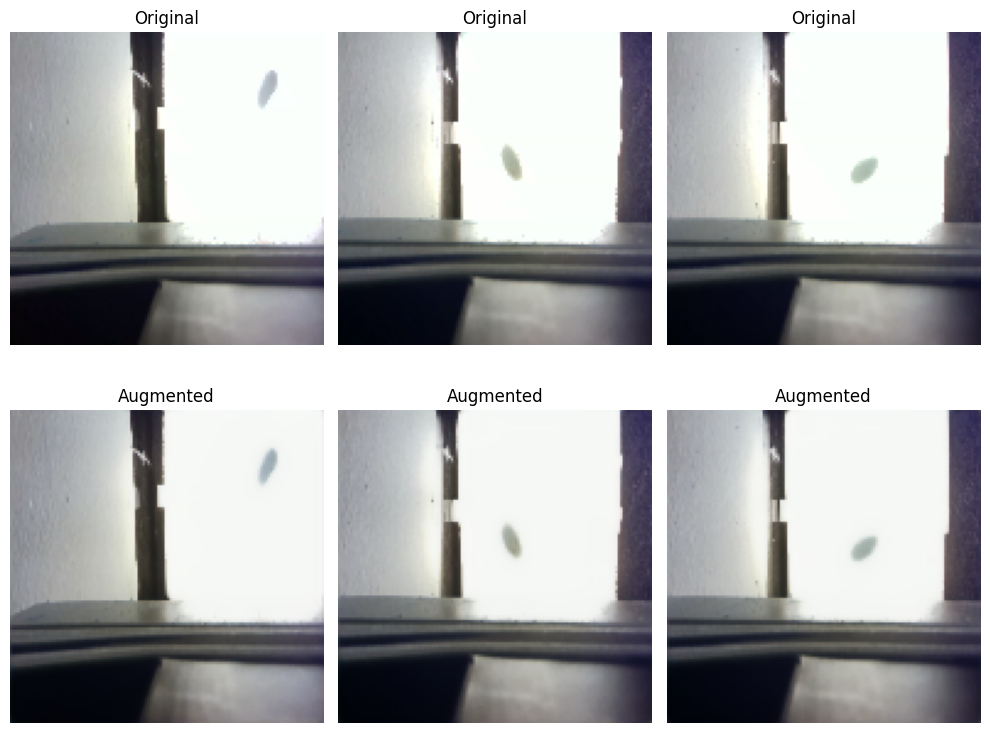

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # 🛠️ NEW: Required for splitting data
import shutil # 🛠️ NEW: Required for label copying

# === CONFIGURATION ===
IMG_SIZE = 128
NOISE_STD_DEV = 0.01 # Standard deviation for Gaussian Noise (Augmentation factor)
SSIM_WEIGHT = 0.4    # Weight for SSIM Loss (0.6 for MSE)
EPOCHS = 30
BATCH_SIZE = 16

# 🛠️ ADJUST THESE PATHS:
base_dir = "/content/tiget" # Original images assumed to be here or in a subfolder
output_dir = "/content/gdrive/MyDrive/cae_aug1" # Output directory for augmented images/labels
SOURCE_IMAGE_DIR = base_dir # Assuming images are directly in /content/tiget/ for simplicity. Adjust if needed.

os.makedirs(output_dir, exist_ok=True)

# === IMAGE LOADING AND DATA SPLIT (FIXED) ===
def load_all_images_from_folder(folder):
    """Loads, resizes, and normalizes ALL images from a single folder."""
    imgs = []
    filenames = []
    if not os.path.exists(folder):
        print(f"Error: Source directory not found at {folder}")
        return np.array(imgs), filenames

    for filename in sorted(os.listdir(folder)):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img = cv2.imread(os.path.join(folder, filename))
            if img is None:
                print(f"Warning: Could not load image {filename}")
                continue

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype("float32") / 255.0
            imgs.append(img)
            filenames.append(filename)
    return np.array(imgs), filenames

print("Loading and preprocessing all data...")
all_imgs, all_names = load_all_images_from_folder(SOURCE_IMAGE_DIR)

if len(all_imgs) > 0:
    # 🛠️ FIX: Split the loaded data into train (80%) and val (20%)
    train_imgs, val_imgs, train_names, val_names = train_test_split(
        all_imgs, all_names, test_size=0.2, random_state=42
    )
    print(f"Total images loaded: {len(all_imgs)}")
    print(f"Train images split: {len(train_imgs)}, Validation images split: {len(val_imgs)}")
else:
    raise RuntimeError(f"FATAL ERROR: No images were loaded. Check if images exist in {SOURCE_IMAGE_DIR}")


# === REFINED CAE MODEL (U-Net style with Noise Injection) ===
def build_sharp_cae():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # ENCODER
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    p1 = layers.MaxPooling2D((2,2))(c1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2,2))(c2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    b = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p3)

    # Inject Gaussian Noise into the Latent Space for augmentation
    noisy_b = layers.GaussianNoise(NOISE_STD_DEV)(b)

    # DECODER with skip connections
    u3 = layers.UpSampling2D((2,2))(noisy_b)
    m3 = layers.Concatenate()([u3, c3])
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(m3)

    u2 = layers.UpSampling2D((2,2))(c4)
    m2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(m2)

    u1 = layers.UpSampling2D((2,2))(c5)
    m1 = layers.Concatenate()([u1, c1])
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(m1)

    out = layers.Conv2D(3, (1,1), activation='sigmoid', padding='same')(c6)
    return models.Model(inp, out)

# === CUSTOM LOSS ===
def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return (1.0 - SSIM_WEIGHT) * mse + SSIM_WEIGHT * ssim_loss

# === TRAIN ===
sharp_cae = build_sharp_cae()
sharp_cae.compile(optimizer='adam', loss=combined_loss)

print("Starting CAE training...")
sharp_cae.fit(train_imgs, train_imgs,
              validation_data=(val_imgs, val_imgs),
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              verbose=1)

# === GENERATE AND SAVE OUTPUTS ===
print("Generating augmented images and saving...")
for split, imgs, names in zip(["train", "val"], [train_imgs, val_imgs], [train_names, val_names]):
    out_dir = os.path.join(output_dir, split, "images")
    os.makedirs(out_dir, exist_ok=True)
    preds = sharp_cae.predict(imgs)
    for i, img in enumerate(preds):
        out_path = os.path.join(out_dir, f"cae_{names[i]}")
        cv2.imwrite(out_path, (img * 255).astype(np.uint8))

print(f"✅ CAE augmentation complete. Outputs saved to: {output_dir}")


# === SSIM CHECK (Quality Assurance) ===
avg_ssim_score = 0
count = 0
# Use a sample of images for SSIM check to keep it fast
sample_size = min(len(train_imgs), 50)
sample_indices = np.random.choice(len(train_imgs), sample_size, replace=False)

for i in sample_indices:
    original_img = (train_imgs[i] * 255).astype(np.uint8)

    predicted_img = sharp_cae.predict(np.expand_dims(train_imgs[i], 0))[0]
    predicted_img = (predicted_img * 255).astype(np.uint8)

    original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    predicted_gray = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2GRAY)

    score, _ = ssim(original_gray, predicted_gray, full=True)
    avg_ssim_score += score
    count += 1

final_avg_ssim = avg_ssim_score / count
print(f"\n✨ Average SSIM between Original and Augmented Images (Sampled): {final_avg_ssim:.4f}")

# Display success message based on expected range
if 0.8 <= final_avg_ssim <= 0.95:
    print("Augmentation quality looks GOOD! Ready to copy labels.")
else:
    print("SSIM value is outside the ideal range (0.8 - 0.95). Consider adjusting NOISE_STD_DEV.")


# === VISUALIZE 3 IMAGES SIDE BY SIDE (Unchanged) ===
num_display = min(3, len(train_imgs))
plt.figure(figsize=(10, 8))
for i in range(num_display):
    # Original
    plt.subplot(2, num_display, i+1)
    plt.imshow((train_imgs[i]*255).astype(np.uint8))
    plt.axis('off')
    plt.title(f"Original")

    # Augmented
    plt.subplot(2, num_display, i+1+num_display)
    aug_img_display = sharp_cae.predict(np.expand_dims(train_imgs[i],0))[0]
    plt.imshow((aug_img_display*255).astype(np.uint8))
    plt.axis('off')
    plt.title(f"Augmented")

plt.tight_layout()
plt.show()

Loading and preprocessing all data...
Total images loaded: 304
Train images split: 243, Validation images split: 61
Starting CAE training...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 362ms/step - loss: 0.2057 - val_loss: 0.1164
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0884 - val_loss: 0.0413
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0413 - val_loss: 0.0248
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0236 - val_loss: 0.0161
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0158 - val_loss: 0.0115
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0121 - val_loss: 0.0103
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0109 - val_loss: 0.0099
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0095 - val_loss: 0.0072
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0075 - val_loss: 0.0091
Epoch 

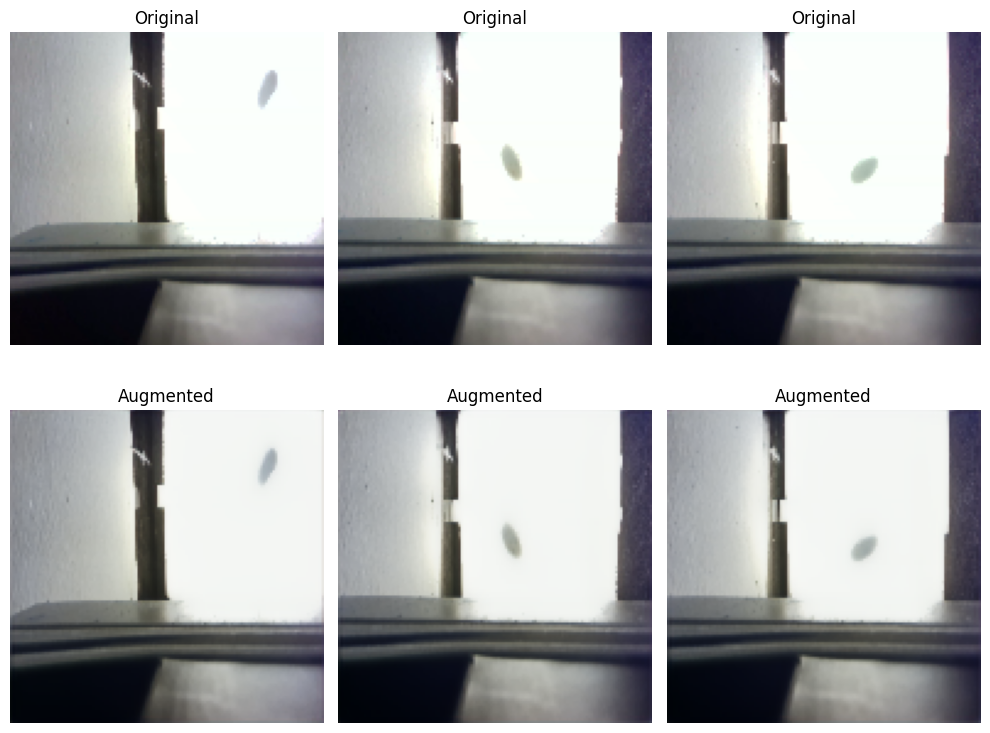

In [ ]:
#cae TRIAL 2 CHANGES: NOISE_STD_DEV INCREASED FROM 0.01 TO 0.05
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # 🛠️ NEW: Required for splitting data
import shutil # 🛠️ NEW: Required for label copying

# === CONFIGURATION ===
IMG_SIZE = 128
NOISE_STD_DEV = 0.05 # Standard deviation for Gaussian Noise (Augmentation factor)
SSIM_WEIGHT = 0.4    # Weight for SSIM Loss (0.6 for MSE)
EPOCHS = 30
BATCH_SIZE = 16

# 🛠️ ADJUST THESE PATHS:
base_dir = "/content/tiget" # Original images assumed to be here or in a subfolder
output_dir = "/content/gdrive/MyDrive/cae_aug1" # Output directory for augmented images/labels
SOURCE_IMAGE_DIR = base_dir # Assuming images are directly in /content/tiget/ for simplicity. Adjust if needed.

os.makedirs(output_dir, exist_ok=True)

# === IMAGE LOADING AND DATA SPLIT (FIXED) ===
def load_all_images_from_folder(folder):
    """Loads, resizes, and normalizes ALL images from a single folder."""
    imgs = []
    filenames = []
    if not os.path.exists(folder):
        print(f"Error: Source directory not found at {folder}")
        return np.array(imgs), filenames

    for filename in sorted(os.listdir(folder)):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img = cv2.imread(os.path.join(folder, filename))
            if img is None:
                print(f"Warning: Could not load image {filename}")
                continue

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype("float32") / 255.0
            imgs.append(img)
            filenames.append(filename)
    return np.array(imgs), filenames

print("Loading and preprocessing all data...")
all_imgs, all_names = load_all_images_from_folder(SOURCE_IMAGE_DIR)

if len(all_imgs) > 0:
    # 🛠️ FIX: Split the loaded data into train (80%) and val (20%)
    train_imgs, val_imgs, train_names, val_names = train_test_split(
        all_imgs, all_names, test_size=0.2, random_state=42
    )
    print(f"Total images loaded: {len(all_imgs)}")
    print(f"Train images split: {len(train_imgs)}, Validation images split: {len(val_imgs)}")
else:
    raise RuntimeError(f"FATAL ERROR: No images were loaded. Check if images exist in {SOURCE_IMAGE_DIR}")


# === REFINED CAE MODEL (U-Net style with Noise Injection) ===
def build_sharp_cae():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # ENCODER
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    p1 = layers.MaxPooling2D((2,2))(c1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2,2))(c2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    b = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p3)

    # Inject Gaussian Noise into the Latent Space for augmentation
    noisy_b = layers.GaussianNoise(NOISE_STD_DEV)(b)

    # DECODER with skip connections
    u3 = layers.UpSampling2D((2,2))(noisy_b)
    m3 = layers.Concatenate()([u3, c3])
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(m3)

    u2 = layers.UpSampling2D((2,2))(c4)
    m2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(m2)

    u1 = layers.UpSampling2D((2,2))(c5)
    m1 = layers.Concatenate()([u1, c1])
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(m1)

    out = layers.Conv2D(3, (1,1), activation='sigmoid', padding='same')(c6)
    return models.Model(inp, out)

# === CUSTOM LOSS ===
def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return (1.0 - SSIM_WEIGHT) * mse + SSIM_WEIGHT * ssim_loss

# === TRAIN ===
sharp_cae = build_sharp_cae()
sharp_cae.compile(optimizer='adam', loss=combined_loss)

print("Starting CAE training...")
sharp_cae.fit(train_imgs, train_imgs,
              validation_data=(val_imgs, val_imgs),
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              verbose=1)

# === GENERATE AND SAVE OUTPUTS ===
print("Generating augmented images and saving...")
for split, imgs, names in zip(["train", "val"], [train_imgs, val_imgs], [train_names, val_names]):
    out_dir = os.path.join(output_dir, split, "images")
    os.makedirs(out_dir, exist_ok=True)
    preds = sharp_cae.predict(imgs)
    for i, img in enumerate(preds):
        out_path = os.path.join(out_dir, f"cae_{names[i]}")
        cv2.imwrite(out_path, (img * 255).astype(np.uint8))

print(f"✅ CAE augmentation complete. Outputs saved to: {output_dir}")


# === SSIM CHECK (Quality Assurance) ===
avg_ssim_score = 0
count = 0
# Use a sample of images for SSIM check to keep it fast
sample_size = min(len(train_imgs), 50)
sample_indices = np.random.choice(len(train_imgs), sample_size, replace=False)

for i in sample_indices:
    original_img = (train_imgs[i] * 255).astype(np.uint8)

    predicted_img = sharp_cae.predict(np.expand_dims(train_imgs[i], 0))[0]
    predicted_img = (predicted_img * 255).astype(np.uint8)

    original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    predicted_gray = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2GRAY)

    score, _ = ssim(original_gray, predicted_gray, full=True)
    avg_ssim_score += score
    count += 1

final_avg_ssim = avg_ssim_score / count
print(f"\n✨ Average SSIM between Original and Augmented Images (Sampled): {final_avg_ssim:.4f}")

# Display success message based on expected range
if 0.8 <= final_avg_ssim <= 0.95:
    print("Augmentation quality looks GOOD! Ready to copy labels.")
else:
    print("SSIM value is outside the ideal range (0.8 - 0.95). Consider adjusting NOISE_STD_DEV.")


# === VISUALIZE 3 IMAGES SIDE BY SIDE (Unchanged) ===
num_display = min(3, len(train_imgs))
plt.figure(figsize=(10, 8))
for i in range(num_display):
    # Original
    plt.subplot(2, num_display, i+1)
    plt.imshow((train_imgs[i]*255).astype(np.uint8))
    plt.axis('off')
    plt.title(f"Original")

    # Augmented
    plt.subplot(2, num_display, i+1+num_display)
    aug_img_display = sharp_cae.predict(np.expand_dims(train_imgs[i],0))[0]
    plt.imshow((aug_img_display*255).astype(np.uint8))
    plt.axis('off')
    plt.title(f"Augmented")

plt.tight_layout()
plt.show()

Loading and preprocessing all data...
Total images loaded: 304
Train images split: 243, Validation images split: 61
Starting CAE training...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 414ms/step - loss: 0.1968 - val_loss: 0.0934
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0848 - val_loss: 0.0440
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0391 - val_loss: 0.0258
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0243 - val_loss: 0.0170
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0163 - val_loss: 0.0123
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0126 - val_loss: 0.0129
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0174 - val_loss: 0.0103
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0108 - val_loss: 0.0091
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0092 - val_loss: 0.0073
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0076 - val_loss: 0.0066
Epoch 

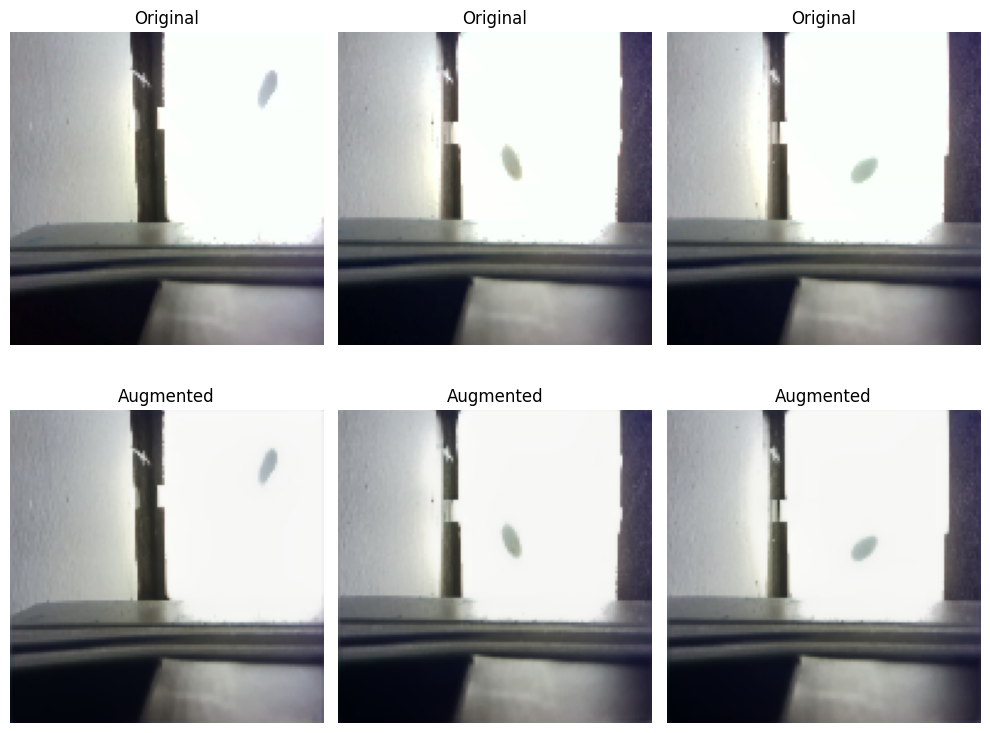

In [ ]:
#cae TRIAL 3 CHANGES: NOISE_STD_DEV INCREASED FROM 0.05 TO 0.15
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # 🛠️ NEW: Required for splitting data
import shutil # 🛠️ NEW: Required for label copying

# === CONFIGURATION ===
IMG_SIZE = 128
NOISE_STD_DEV = 0.05 # Standard deviation for Gaussian Noise (Augmentation factor)
SSIM_WEIGHT = 0.4    # Weight for SSIM Loss (0.6 for MSE)
EPOCHS = 30
BATCH_SIZE = 16

# 🛠️ ADJUST THESE PATHS:
base_dir = "/content/tiget" # Original images assumed to be here or in a subfolder
output_dir = "/content/gdrive/MyDrive/cae_aug1" # Output directory for augmented images/labels
SOURCE_IMAGE_DIR = base_dir # Assuming images are directly in /content/tiget/ for simplicity. Adjust if needed.

os.makedirs(output_dir, exist_ok=True)

# === IMAGE LOADING AND DATA SPLIT (FIXED) ===
def load_all_images_from_folder(folder):
    """Loads, resizes, and normalizes ALL images from a single folder."""
    imgs = []
    filenames = []
    if not os.path.exists(folder):
        print(f"Error: Source directory not found at {folder}")
        return np.array(imgs), filenames

    for filename in sorted(os.listdir(folder)):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img = cv2.imread(os.path.join(folder, filename))
            if img is None:
                print(f"Warning: Could not load image {filename}")
                continue

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype("float32") / 255.0
            imgs.append(img)
            filenames.append(filename)
    return np.array(imgs), filenames

print("Loading and preprocessing all data...")
all_imgs, all_names = load_all_images_from_folder(SOURCE_IMAGE_DIR)

if len(all_imgs) > 0:
    # 🛠️ FIX: Split the loaded data into train (80%) and val (20%)
    train_imgs, val_imgs, train_names, val_names = train_test_split(
        all_imgs, all_names, test_size=0.2, random_state=42
    )
    print(f"Total images loaded: {len(all_imgs)}")
    print(f"Train images split: {len(train_imgs)}, Validation images split: {len(val_imgs)}")
else:
    raise RuntimeError(f"FATAL ERROR: No images were loaded. Check if images exist in {SOURCE_IMAGE_DIR}")


# === REFINED CAE MODEL (U-Net style with Noise Injection) ===
def build_sharp_cae():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # ENCODER
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    p1 = layers.MaxPooling2D((2,2))(c1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2,2))(c2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    b = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p3)

    # Inject Gaussian Noise into the Latent Space for augmentation
    noisy_b = layers.GaussianNoise(NOISE_STD_DEV)(b)

    # DECODER with skip connections
    u3 = layers.UpSampling2D((2,2))(noisy_b)
    m3 = layers.Concatenate()([u3, c3])
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(m3)

    u2 = layers.UpSampling2D((2,2))(c4)
    m2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(m2)

    u1 = layers.UpSampling2D((2,2))(c5)
    m1 = layers.Concatenate()([u1, c1])
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(m1)

    out = layers.Conv2D(3, (1,1), activation='sigmoid', padding='same')(c6)
    return models.Model(inp, out)

# === CUSTOM LOSS ===
def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return (1.0 - SSIM_WEIGHT) * mse + SSIM_WEIGHT * ssim_loss

# === TRAIN ===
sharp_cae = build_sharp_cae()
sharp_cae.compile(optimizer='adam', loss=combined_loss)

print("Starting CAE training...")
sharp_cae.fit(train_imgs, train_imgs,
              validation_data=(val_imgs, val_imgs),
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              verbose=1)

# === GENERATE AND SAVE OUTPUTS ===
print("Generating augmented images and saving...")
for split, imgs, names in zip(["train", "val"], [train_imgs, val_imgs], [train_names, val_names]):
    out_dir = os.path.join(output_dir, split, "images")
    os.makedirs(out_dir, exist_ok=True)
    preds = sharp_cae.predict(imgs)
    for i, img in enumerate(preds):
        out_path = os.path.join(out_dir, f"cae_{names[i]}")
        cv2.imwrite(out_path, (img * 255).astype(np.uint8))

print(f"✅ CAE augmentation complete. Outputs saved to: {output_dir}")


# === SSIM CHECK (Quality Assurance) ===
avg_ssim_score = 0
count = 0
# Use a sample of images for SSIM check to keep it fast
sample_size = min(len(train_imgs), 50)
sample_indices = np.random.choice(len(train_imgs), sample_size, replace=False)

for i in sample_indices:
    original_img = (train_imgs[i] * 255).astype(np.uint8)

    predicted_img = sharp_cae.predict(np.expand_dims(train_imgs[i], 0))[0]
    predicted_img = (predicted_img * 255).astype(np.uint8)

    original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    predicted_gray = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2GRAY)

    score, _ = ssim(original_gray, predicted_gray, full=True)
    avg_ssim_score += score
    count += 1

final_avg_ssim = avg_ssim_score / count
print(f"\n✨ Average SSIM between Original and Augmented Images (Sampled): {final_avg_ssim:.4f}")

# Display success message based on expected range
if 0.8 <= final_avg_ssim <= 0.95:
    print("Augmentation quality looks GOOD! Ready to copy labels.")
else:
    print("SSIM value is outside the ideal range (0.8 - 0.95). Consider adjusting NOISE_STD_DEV.")


# === VISUALIZE 3 IMAGES SIDE BY SIDE (Unchanged) ===
num_display = min(3, len(train_imgs))
plt.figure(figsize=(10, 8))
for i in range(num_display):
    # Original
    plt.subplot(2, num_display, i+1)
    plt.imshow((train_imgs[i]*255).astype(np.uint8))
    plt.axis('off')
    plt.title(f"Original")

    # Augmented
    plt.subplot(2, num_display, i+1+num_display)
    aug_img_display = sharp_cae.predict(np.expand_dims(train_imgs[i],0))[0]
    plt.imshow((aug_img_display*255).astype(np.uint8))
    plt.axis('off')
    plt.title(f"Augmented")

plt.tight_layout()
plt.show()

Loading and preprocessing all data...
Total images loaded: 304
Train images split: 243, Validation images split: 61
Starting CAE training...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 443ms/step - loss: 0.3116 - val_loss: 0.1443
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.1128 - val_loss: 0.0602
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0545 - val_loss: 0.0344
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0322 - val_loss: 0.0209
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0238 - val_loss: 0.0221
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0205 - val_loss: 0.0155
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0160 - val_loss: 0.0121
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0123 - val_loss: 0.0109
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0113 - val_loss: 0.0096
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 

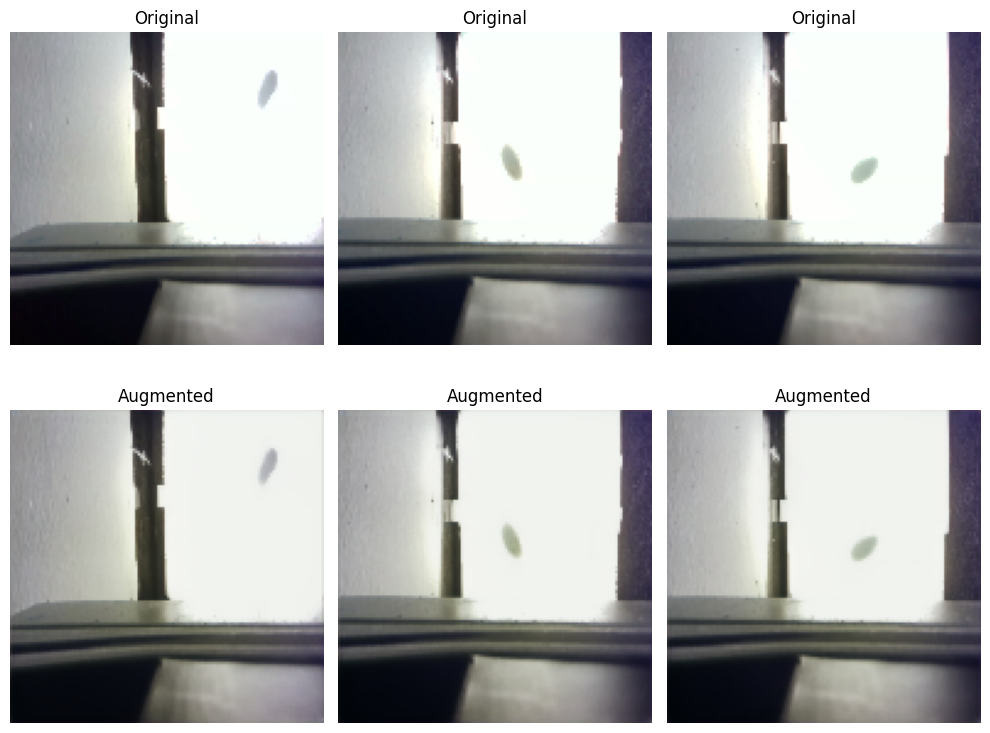

In [ ]:
#cae TRIAL 4 CHANGES: NOISE_STD_DEV INCREASED FROM 0.15 TO 0.05 AND SSIM_WT FROM 0.4 TO 0.6
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # 🛠️ NEW: Required for splitting data
import shutil # 🛠️ NEW: Required for label copying

# === CONFIGURATION ===
IMG_SIZE = 128
NOISE_STD_DEV = 0.05 # Standard deviation for Gaussian Noise (Augmentation factor)
SSIM_WEIGHT = 0.6    # Weight for SSIM Loss (0.6 for MSE)
EPOCHS = 30
BATCH_SIZE = 16

# 🛠️ ADJUST THESE PATHS:
base_dir = "/content/tiget" # Original images assumed to be here or in a subfolder
output_dir = "/content/gdrive/MyDrive/cae_aug1" # Output directory for augmented images/labels
SOURCE_IMAGE_DIR = base_dir # Assuming images are directly in /content/tiget/ for simplicity. Adjust if needed.

os.makedirs(output_dir, exist_ok=True)

# === IMAGE LOADING AND DATA SPLIT (FIXED) ===
def load_all_images_from_folder(folder):
    """Loads, resizes, and normalizes ALL images from a single folder."""
    imgs = []
    filenames = []
    if not os.path.exists(folder):
        print(f"Error: Source directory not found at {folder}")
        return np.array(imgs), filenames

    for filename in sorted(os.listdir(folder)):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img = cv2.imread(os.path.join(folder, filename))
            if img is None:
                print(f"Warning: Could not load image {filename}")
                continue

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype("float32") / 255.0
            imgs.append(img)
            filenames.append(filename)
    return np.array(imgs), filenames

print("Loading and preprocessing all data...")
all_imgs, all_names = load_all_images_from_folder(SOURCE_IMAGE_DIR)

if len(all_imgs) > 0:
    # 🛠️ FIX: Split the loaded data into train (80%) and val (20%)
    train_imgs, val_imgs, train_names, val_names = train_test_split(
        all_imgs, all_names, test_size=0.2, random_state=42
    )
    print(f"Total images loaded: {len(all_imgs)}")
    print(f"Train images split: {len(train_imgs)}, Validation images split: {len(val_imgs)}")
else:
    raise RuntimeError(f"FATAL ERROR: No images were loaded. Check if images exist in {SOURCE_IMAGE_DIR}")


# === REFINED CAE MODEL (U-Net style with Noise Injection) ===
def build_sharp_cae():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # ENCODER
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    p1 = layers.MaxPooling2D((2,2))(c1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2,2))(c2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    b = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p3)

    # Inject Gaussian Noise into the Latent Space for augmentation
    noisy_b = layers.GaussianNoise(NOISE_STD_DEV)(b)

    # DECODER with skip connections
    u3 = layers.UpSampling2D((2,2))(noisy_b)
    m3 = layers.Concatenate()([u3, c3])
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(m3)

    u2 = layers.UpSampling2D((2,2))(c4)
    m2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(m2)

    u1 = layers.UpSampling2D((2,2))(c5)
    m1 = layers.Concatenate()([u1, c1])
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(m1)

    out = layers.Conv2D(3, (1,1), activation='sigmoid', padding='same')(c6)
    return models.Model(inp, out)

# === CUSTOM LOSS ===
def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return (1.0 - SSIM_WEIGHT) * mse + SSIM_WEIGHT * ssim_loss

# === TRAIN ===
sharp_cae = build_sharp_cae()
sharp_cae.compile(optimizer='adam', loss=combined_loss)

print("Starting CAE training...")
sharp_cae.fit(train_imgs, train_imgs,
              validation_data=(val_imgs, val_imgs),
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              verbose=1)

# === GENERATE AND SAVE OUTPUTS ===
print("Generating augmented images and saving...")
for split, imgs, names in zip(["train", "val"], [train_imgs, val_imgs], [train_names, val_names]):
    out_dir = os.path.join(output_dir, split, "images")
    os.makedirs(out_dir, exist_ok=True)
    preds = sharp_cae.predict(imgs)
    for i, img in enumerate(preds):
        out_path = os.path.join(out_dir, f"cae_{names[i]}")
        cv2.imwrite(out_path, (img * 255).astype(np.uint8))

print(f"✅ CAE augmentation complete. Outputs saved to: {output_dir}")


# === SSIM CHECK (Quality Assurance) ===
avg_ssim_score = 0
count = 0
# Use a sample of images for SSIM check to keep it fast
sample_size = min(len(train_imgs), 50)
sample_indices = np.random.choice(len(train_imgs), sample_size, replace=False)

for i in sample_indices:
    original_img = (train_imgs[i] * 255).astype(np.uint8)

    predicted_img = sharp_cae.predict(np.expand_dims(train_imgs[i], 0))[0]
    predicted_img = (predicted_img * 255).astype(np.uint8)

    original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    predicted_gray = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2GRAY)

    score, _ = ssim(original_gray, predicted_gray, full=True)
    avg_ssim_score += score
    count += 1

final_avg_ssim = avg_ssim_score / count
print(f"\n✨ Average SSIM between Original and Augmented Images (Sampled): {final_avg_ssim:.4f}")

# Display success message based on expected range
if 0.8 <= final_avg_ssim <= 0.95:
    print("Augmentation quality looks GOOD! Ready to copy labels.")
else:
    print("SSIM value is outside the ideal range (0.8 - 0.95). Consider adjusting NOISE_STD_DEV.")


# === VISUALIZE 3 IMAGES SIDE BY SIDE (Unchanged) ===
num_display = min(3, len(train_imgs))
plt.figure(figsize=(10, 8))
for i in range(num_display):
    # Original
    plt.subplot(2, num_display, i+1)
    plt.imshow((train_imgs[i]*255).astype(np.uint8))
    plt.axis('off')
    plt.title(f"Original")

    # Augmented
    plt.subplot(2, num_display, i+1+num_display)
    aug_img_display = sharp_cae.predict(np.expand_dims(train_imgs[i],0))[0]
    plt.imshow((aug_img_display*255).astype(np.uint8))
    plt.axis('off')
    plt.title(f"Augmented")

plt.tight_layout()
plt.show()

Loading and preprocessing all data...
Total images loaded: 304
Train images split: 243, Validation images split: 61
Starting CAE training...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 365ms/step - loss: 0.3285 - val_loss: 0.1484
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.1197 - val_loss: 0.0730
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0645 - val_loss: 0.0397
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0392 - val_loss: 0.0288
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0279 - val_loss: 0.0225
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0214 - val_loss: 0.0182
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0179 - val_loss: 0.0145
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0150 - val_loss: 0.0131
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0138 - val_loss: 0.0124
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0124 - val_loss: 0.0118
Epoch 

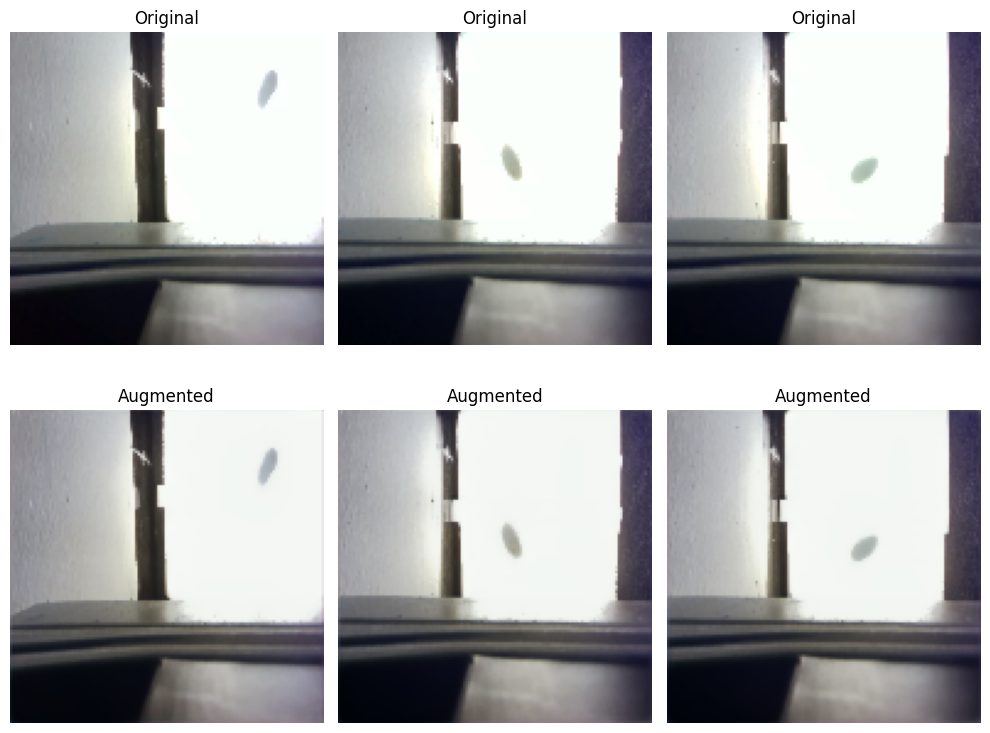

In [ ]:
#cae TRAIL 5 CHNAGES: NOISE_STD_DEV FROM 0.05 TO 0.07 AND SSIM_WT FROM 0.6 TO 0.75
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil

# === CONFIGURATION (FINAL ADJUSTMENT) ===
IMG_SIZE = 128
NOISE_STD_DEV = 0.07  # Reverted to a controlled level
SSIM_WEIGHT = 0.75   # 🛠️ FINAL FIX: Increased SSIM weight to dominate the loss (75%)
EPOCHS = 30
BATCH_SIZE = 16

# 🛠️ ADJUST THESE PATHS:
base_dir = "/content/tiget"
output_dir = "/content/gdrive/MyDrive/cae_aug1"
SOURCE_IMAGE_DIR = base_dir

os.makedirs(output_dir, exist_ok=True)

# === IMAGE LOADING AND DATA SPLIT (FIXED) ===
def load_all_images_from_folder(folder):
    """Loads, resizes, and normalizes ALL images from a single folder."""
    imgs = []
    filenames = []
    if not os.path.exists(folder):
        print(f"Error: Source directory not found at {folder}")
        return np.array(imgs), filenames

    for filename in sorted(os.listdir(folder)):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img = cv2.imread(os.path.join(folder, filename))
            if img is None: continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype("float32") / 255.0
            imgs.append(img)
            filenames.append(filename)
    return np.array(imgs), filenames

print("Loading and preprocessing all data...")
all_imgs, all_names = load_all_images_from_folder(SOURCE_IMAGE_DIR)

if len(all_imgs) > 0:
    train_imgs, val_imgs, train_names, val_names = train_test_split(
        all_imgs, all_names, test_size=0.2, random_state=42
    )
    print(f"Total images loaded: {len(all_imgs)}")
    print(f"Train images split: {len(train_imgs)}, Validation images split: {len(val_imgs)}")
else:
    raise RuntimeError(f"FATAL ERROR: No images were loaded. Check if images exist in {SOURCE_IMAGE_DIR}")


# === REFINED CAE MODEL (U-Net style with Noise Injection) ===
def build_sharp_cae():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # ENCODER (UNCHANGED)
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp); p1 = layers.MaxPooling2D((2,2))(c1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1); p2 = layers.MaxPooling2D((2,2))(c2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2); p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    b = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p3)

    # Inject Gaussian Noise
    noisy_b = layers.GaussianNoise(NOISE_STD_DEV)(b)

    # DECODER (UNCHANGED)
    u3 = layers.UpSampling2D((2,2))(noisy_b); m3 = layers.Concatenate()([u3, c3])
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(m3)
    u2 = layers.UpSampling2D((2,2))(c4); m2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(m2)
    u1 = layers.UpSampling2D((2,2))(c5); m1 = layers.Concatenate()([u1, c1])
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(m1)

    out = layers.Conv2D(3, (1,1), activation='sigmoid', padding='same')(c6)
    return models.Model(inp, out)

# === CUSTOM LOSS (UPDATED SSIM WEIGHT) ===
def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    # CRITICAL: Use the new SSIM_WEIGHT
    return (1.0 - SSIM_WEIGHT) * mse + SSIM_WEIGHT * ssim_loss

# === TRAIN (Rest of the code is unchanged) ===
sharp_cae = build_sharp_cae()
sharp_cae.compile(optimizer='adam', loss=combined_loss)

print("Starting CAE training...")
sharp_cae.fit(train_imgs, train_imgs, validation_data=(val_imgs, val_imgs), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

print("Generating augmented images and saving...")
for split, imgs, names in zip(["train", "val"], [train_imgs, val_imgs], [train_names, val_names]):
    out_dir = os.path.join(output_dir, split, "images")
    os.makedirs(out_dir, exist_ok=True)
    preds = sharp_cae.predict(imgs)
    for i, img in enumerate(preds):
        out_path = os.path.join(out_dir, f"cae_{names[i]}")
        cv2.imwrite(out_path, (img * 255).astype(np.uint8))

print(f"✅ CAE augmentation complete. Outputs saved to: {output_dir}")


# === SSIM CHECK (Quality Assurance) ===
avg_ssim_score = 0
count = 0
sample_size = min(len(train_imgs), 50)
sample_indices = np.random.choice(len(train_imgs), sample_size, replace=False)

for i in sample_indices:
    original_img = (train_imgs[i] * 255).astype(np.uint8)
    predicted_img = sharp_cae.predict(np.expand_dims(train_imgs[i], 0))[0]
    predicted_img = (predicted_img * 255).astype(np.uint8)

    original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    predicted_gray = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2GRAY)

    score, _ = ssim(original_gray, predicted_gray, full=True)
    avg_ssim_score += score
    count += 1

final_avg_ssim = avg_ssim_score / count
print(f"\n✨ Average SSIM between Original and Augmented Images (Sampled): {final_avg_ssim:.4f}")

if 0.8 <= final_avg_ssim <= 0.95:
    print("Augmentation quality looks GOOD! Ready to copy labels.")
else:
    print("SSIM value is outside the ideal range (0.8 - 0.95). Consider adjusting NOISE_STD_DEV.")


# === VISUALIZE 3 IMAGES SIDE BY SIDE ===
num_display = min(3, len(train_imgs))
plt.figure(figsize=(10, 8))
for i in range(num_display):
    plt.subplot(2, num_display, i+1)
    plt.imshow((train_imgs[i]*255).astype(np.uint8)); plt.axis('off'); plt.title(f"Original")
    plt.subplot(2, num_display, i+1+num_display)
    aug_img_display = sharp_cae.predict(np.expand_dims(train_imgs[i],0))[0]
    plt.imshow((aug_img_display*255).astype(np.uint8)); plt.axis('off'); plt.title(f"Augmented")

plt.tight_layout()
plt.show()

Loading and preprocessing all data...
Total images loaded: 304
Train images split: 243, Validation images split: 61
Starting CAE training...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 536ms/step - loss: 0.3589 - val_loss: 0.1613
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.1437 - val_loss: 0.0774
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0696 - val_loss: 0.0487
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0445 - val_loss: 0.0328
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0324 - val_loss: 0.0269
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0258 - val_loss: 0.0207
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0209 - val_loss: 0.0179
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0181 - val_loss: 0.0160
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0163 - val_loss: 0.0128
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0134 - val_loss: 0.0134
Epoch 

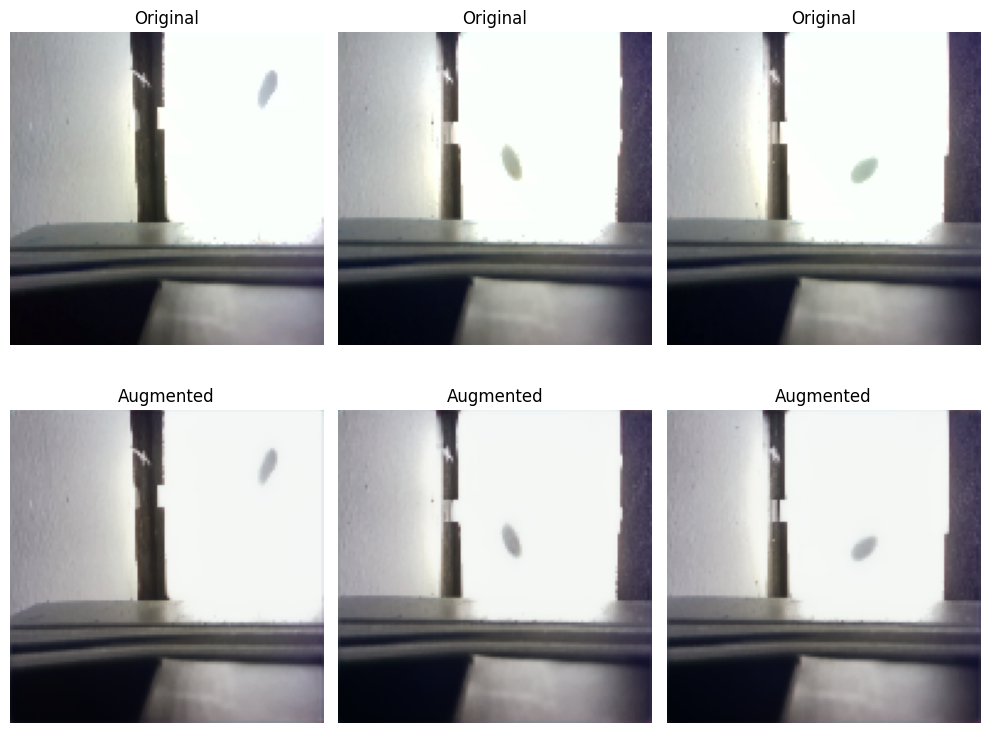

In [ ]:
#cae TRAIL 6 CHANGES: 1. ✂️ Weaken Skip Connections
#Instead of removing the skip connections entirely (which might ruin the image completely), we'll add a Conv2D layer to the skip connection path. This layer will force the skip information to be processed and compressed before being merged with the upsampled layer, making the reconstruction less direct and giving the noise a stronger influence.
#
#2. ⚙️ Implement the Change (Weaken c1, c2, c3 in Decoder)
#We will modify the build_sharp_cae function to include this filtering layer. We'll also keep the SSIM_WEIGHT high and the NOISE_STD_DEV controlled.
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil

# === CONFIGURATION (Final Refinement) ===
IMG_SIZE = 128
NOISE_STD_DEV = 0.07 # Controlled noise
SSIM_WEIGHT = 0.75   # High SSIM weight to guide structural focus
EPOCHS = 30
BATCH_SIZE = 16

# 🛠️ ADJUST THESE PATHS:
base_dir = "/content/tiget"
output_dir = "/content/gdrive/MyDrive/cae_aug2" # Changed output folder for this trial
SOURCE_IMAGE_DIR = base_dir

os.makedirs(output_dir, exist_ok=True)

# === IMAGE LOADING AND DATA SPLIT (Unchanged) ===
def load_all_images_from_folder(folder):
    """Loads, resizes, and normalizes ALL images from a single folder."""
    imgs = []
    filenames = []
    if not os.path.exists(folder):
        print(f"Error: Source directory not found at {folder}")
        return np.array(imgs), filenames

    for filename in sorted(os.listdir(folder)):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img = cv2.imread(os.path.join(folder, filename))
            if img is None: continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype("float32") / 255.0
            imgs.append(img)
            filenames.append(filename)
    return np.array(imgs), filenames

print("Loading and preprocessing all data...")
all_imgs, all_names = load_all_images_from_folder(SOURCE_IMAGE_DIR)

if len(all_imgs) > 0:
    train_imgs, val_imgs, train_names, val_names = train_test_split(all_imgs, all_names, test_size=0.2, random_state=42)
    print(f"Total images loaded: {len(all_imgs)}")
    print(f"Train images split: {len(train_imgs)}, Validation images split: {len(val_imgs)}")
else:
    raise RuntimeError(f"FATAL ERROR: No images were loaded. Check if images exist in {SOURCE_IMAGE_DIR}")


# === REFINED CAE MODEL (WEAKENED SKIP CONNECTIONS) ===
def build_sharp_cae():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # ENCODER
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp); p1 = layers.MaxPooling2D((2,2))(c1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1); p2 = layers.MaxPooling2D((2,2))(c2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2); p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    b = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p3)
    noisy_b = layers.GaussianNoise(NOISE_STD_DEV)(b)

    # DECODER with WEAKENED skip connections 💣

    # Skip for c3
    filtered_c3 = layers.Conv2D(128, (1, 1), activation='relu', padding='same')(c3) # New filter layer
    u3 = layers.UpSampling2D((2,2))(noisy_b)
    m3 = layers.Concatenate()([u3, filtered_c3]) # Merged with filtered connection
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(m3)

    # Skip for c2
    filtered_c2 = layers.Conv2D(64, (1, 1), activation='relu', padding='same')(c2) # New filter layer
    u2 = layers.UpSampling2D((2,2))(c4)
    m2 = layers.Concatenate()([u2, filtered_c2]) # Merged with filtered connection
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(m2)

    # Skip for c1
    filtered_c1 = layers.Conv2D(32, (1, 1), activation='relu', padding='same')(c1) # New filter layer
    u1 = layers.UpSampling2D((2,2))(c5)
    m1 = layers.Concatenate()([u1, filtered_c1]) # Merged with filtered connection
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(m1)

    out = layers.Conv2D(3, (1,1), activation='sigmoid', padding='same')(c6)
    return models.Model(inp, out)

# === CUSTOM LOSS (Unchanged) ===
def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return (1.0 - SSIM_WEIGHT) * mse + SSIM_WEIGHT * ssim_loss

# === TRAIN (Unchanged) ===
sharp_cae = build_sharp_cae()
sharp_cae.compile(optimizer='adam', loss=combined_loss)

print("Starting CAE training...")
sharp_cae.fit(train_imgs, train_imgs, validation_data=(val_imgs, val_imgs), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

print("Generating augmented images and saving...")
for split, imgs, names in zip(["train", "val"], [train_imgs, val_imgs], [train_names, val_names]):
    out_dir = os.path.join(output_dir, split, "images")
    os.makedirs(out_dir, exist_ok=True)
    preds = sharp_cae.predict(imgs)
    for i, img in enumerate(preds):
        out_path = os.path.join(out_dir, f"cae_{names[i]}")
        cv2.imwrite(out_path, (img * 255).astype(np.uint8))

print(f"✅ CAE augmentation complete. Outputs saved to: {output_dir}")


# === SSIM CHECK (Unchanged) ===
avg_ssim_score = 0
count = 0
sample_size = min(len(train_imgs), 50)
sample_indices = np.random.choice(len(train_imgs), sample_size, replace=False)

for i in sample_indices:
    original_img = (train_imgs[i] * 255).astype(np.uint8)
    predicted_img = sharp_cae.predict(np.expand_dims(train_imgs[i], 0))[0]
    predicted_img = (predicted_img * 255).astype(np.uint8)

    original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    predicted_gray = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2GRAY)

    score, _ = ssim(original_gray, predicted_gray, full=True)
    avg_ssim_score += score
    count += 1

final_avg_ssim = avg_ssim_score / count
print(f"\n✨ Average SSIM between Original and Augmented Images (Sampled): {final_avg_ssim:.4f}")

if 0.8 <= final_avg_ssim <= 0.95:
    print("Augmentation quality looks GOOD! Ready to copy labels.")
else:
    print("SSIM value is outside the ideal range (0.8 - 0.95). **RERUN THIS CODE WITH NOISE_STD_DEV = 0.10**.")


# === VISUALIZE 3 IMAGES SIDE BY SIDE (Unchanged) ===
num_display = min(3, len(train_imgs))
plt.figure(figsize=(10, 8))
for i in range(num_display):
    plt.subplot(2, num_display, i+1)
    plt.imshow((train_imgs[i]*255).astype(np.uint8)); plt.axis('off'); plt.title(f"Original")
    plt.subplot(2, num_display, i+1+num_display)
    aug_img_display = sharp_cae.predict(np.expand_dims(train_imgs[i],0))[0]
    plt.imshow((aug_img_display*255).astype(np.uint8)); plt.axis('off'); plt.title(f"Augmented")

plt.tight_layout()
plt.show()

Loading and preprocessing all data...
Total images loaded: 304
Train images split: 243, Validation images split: 61
Starting CAE training...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 488ms/step - loss: 0.3495 - val_loss: 0.2561
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.1924 - val_loss: 0.0897
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0787 - val_loss: 0.0557
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0465 - val_loss: 0.0352
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0323 - val_loss: 0.0248
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0236 - val_loss: 0.0212
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0193 - val_loss: 0.0160
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0153 - val_loss: 0.0135
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0129 - val_loss: 0.0116
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0114 - val_loss: 0.0097
Epoch 

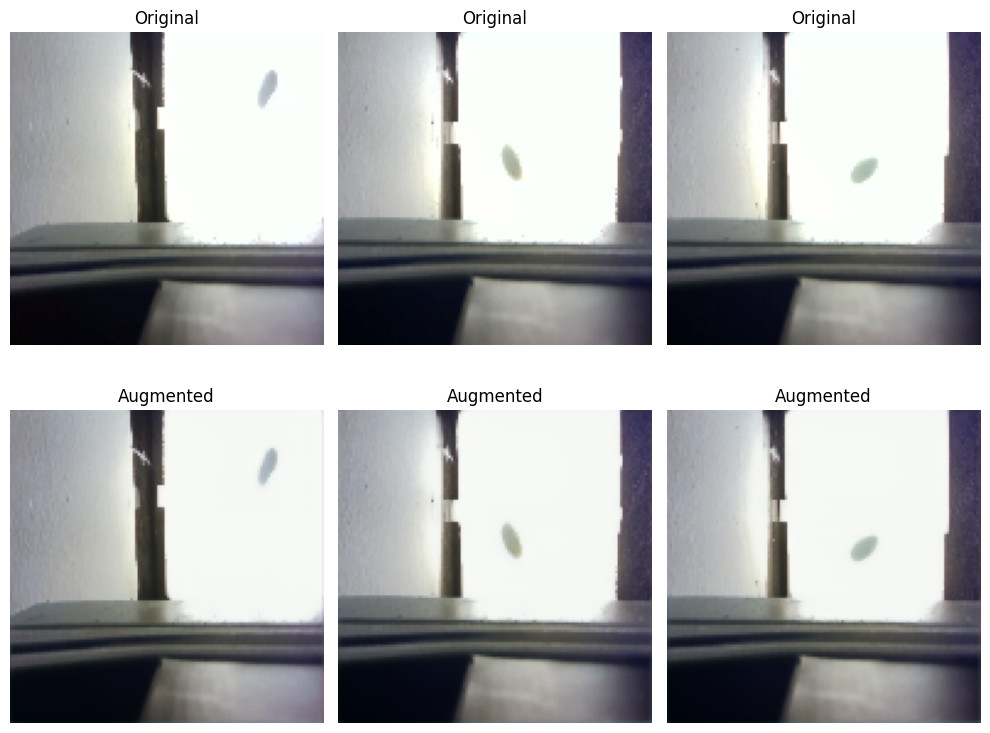

In [ ]:
#cae TRAIL 6 CHANGES: 1. ✂️ Weaken Skip Connections
#Instead of removing the skip connections entirely (which might ruin the image completely), we'll add a Conv2D layer to the skip connection path. This layer will force the skip information to be processed and compressed before being merged with the upsampled layer, making the reconstruction less direct and giving the noise a stronger influence.
#
#2. ⚙️ Implement the Change (Weaken c1, c2, c3 in Decoder)
#We will modify the build_sharp_cae function to include this filtering layer. We'll also keep the SSIM_WEIGHT high and the NOISE_STD_DEV controlled.
#3. noise_std_dev from 0.07 to 0.10
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil

# === CONFIGURATION (Final Refinement) ===
IMG_SIZE = 128
NOISE_STD_DEV = 0.10 # Controlled noise
SSIM_WEIGHT = 0.75   # High SSIM weight to guide structural focus
EPOCHS = 30
BATCH_SIZE = 16

# 🛠️ ADJUST THESE PATHS:
base_dir = "/content/tiget"
output_dir = "/content/gdrive/MyDrive/cae_aug2" # Changed output folder for this trial
SOURCE_IMAGE_DIR = base_dir

os.makedirs(output_dir, exist_ok=True)

# === IMAGE LOADING AND DATA SPLIT (Unchanged) ===
def load_all_images_from_folder(folder):
    """Loads, resizes, and normalizes ALL images from a single folder."""
    imgs = []
    filenames = []
    if not os.path.exists(folder):
        print(f"Error: Source directory not found at {folder}")
        return np.array(imgs), filenames

    for filename in sorted(os.listdir(folder)):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img = cv2.imread(os.path.join(folder, filename))
            if img is None: continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype("float32") / 255.0
            imgs.append(img)
            filenames.append(filename)
    return np.array(imgs), filenames

print("Loading and preprocessing all data...")
all_imgs, all_names = load_all_images_from_folder(SOURCE_IMAGE_DIR)

if len(all_imgs) > 0:
    train_imgs, val_imgs, train_names, val_names = train_test_split(all_imgs, all_names, test_size=0.2, random_state=42)
    print(f"Total images loaded: {len(all_imgs)}")
    print(f"Train images split: {len(train_imgs)}, Validation images split: {len(val_imgs)}")
else:
    raise RuntimeError(f"FATAL ERROR: No images were loaded. Check if images exist in {SOURCE_IMAGE_DIR}")


# === REFINED CAE MODEL (WEAKENED SKIP CONNECTIONS) ===
def build_sharp_cae():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # ENCODER
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp); p1 = layers.MaxPooling2D((2,2))(c1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1); p2 = layers.MaxPooling2D((2,2))(c2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2); p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    b = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p3)
    noisy_b = layers.GaussianNoise(NOISE_STD_DEV)(b)

    # DECODER with WEAKENED skip connections 💣

    # Skip for c3
    filtered_c3 = layers.Conv2D(128, (1, 1), activation='relu', padding='same')(c3) # New filter layer
    u3 = layers.UpSampling2D((2,2))(noisy_b)
    m3 = layers.Concatenate()([u3, filtered_c3]) # Merged with filtered connection
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(m3)

    # Skip for c2
    filtered_c2 = layers.Conv2D(64, (1, 1), activation='relu', padding='same')(c2) # New filter layer
    u2 = layers.UpSampling2D((2,2))(c4)
    m2 = layers.Concatenate()([u2, filtered_c2]) # Merged with filtered connection
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(m2)

    # Skip for c1
    filtered_c1 = layers.Conv2D(32, (1, 1), activation='relu', padding='same')(c1) # New filter layer
    u1 = layers.UpSampling2D((2,2))(c5)
    m1 = layers.Concatenate()([u1, filtered_c1]) # Merged with filtered connection
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(m1)

    out = layers.Conv2D(3, (1,1), activation='sigmoid', padding='same')(c6)
    return models.Model(inp, out)

# === CUSTOM LOSS (Unchanged) ===
def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return (1.0 - SSIM_WEIGHT) * mse + SSIM_WEIGHT * ssim_loss

# === TRAIN (Unchanged) ===
sharp_cae = build_sharp_cae()
sharp_cae.compile(optimizer='adam', loss=combined_loss)

print("Starting CAE training...")
sharp_cae.fit(train_imgs, train_imgs, validation_data=(val_imgs, val_imgs), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

print("Generating augmented images and saving...")
for split, imgs, names in zip(["train", "val"], [train_imgs, val_imgs], [train_names, val_names]):
    out_dir = os.path.join(output_dir, split, "images")
    os.makedirs(out_dir, exist_ok=True)
    preds = sharp_cae.predict(imgs)
    for i, img in enumerate(preds):
        out_path = os.path.join(out_dir, f"cae_{names[i]}")
        cv2.imwrite(out_path, (img * 255).astype(np.uint8))

print(f"✅ CAE augmentation complete. Outputs saved to: {output_dir}")


# === SSIM CHECK (Unchanged) ===
avg_ssim_score = 0
count = 0
sample_size = min(len(train_imgs), 50)
sample_indices = np.random.choice(len(train_imgs), sample_size, replace=False)

for i in sample_indices:
    original_img = (train_imgs[i] * 255).astype(np.uint8)
    predicted_img = sharp_cae.predict(np.expand_dims(train_imgs[i], 0))[0]
    predicted_img = (predicted_img * 255).astype(np.uint8)

    original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    predicted_gray = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2GRAY)

    score, _ = ssim(original_gray, predicted_gray, full=True)
    avg_ssim_score += score
    count += 1

final_avg_ssim = avg_ssim_score / count
print(f"\n✨ Average SSIM between Original and Augmented Images (Sampled): {final_avg_ssim:.4f}")

if 0.8 <= final_avg_ssim <= 0.95:
    print("Augmentation quality looks GOOD! Ready to copy labels.")
else:
    print("SSIM value is outside the ideal range (0.8 - 0.95). **RERUN THIS CODE WITH NOISE_STD_DEV = 0.10**.")


# === VISUALIZE 3 IMAGES SIDE BY SIDE (Unchanged) ===
num_display = min(3, len(train_imgs))
plt.figure(figsize=(10, 8))
for i in range(num_display):
    plt.subplot(2, num_display, i+1)
    plt.imshow((train_imgs[i]*255).astype(np.uint8)); plt.axis('off'); plt.title(f"Original")
    plt.subplot(2, num_display, i+1+num_display)
    aug_img_display = sharp_cae.predict(np.expand_dims(train_imgs[i],0))[0]
    plt.imshow((aug_img_display*255).astype(np.uint8)); plt.axis('off'); plt.title(f"Augmented")

plt.tight_layout()
plt.show()

Loading and preprocessing all data...
Total images loaded: 304
Train images split: 243, Validation images split: 61
Starting CAE training...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 695ms/step - loss: 0.4126 - val_loss: 0.3386
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.3231 - val_loss: 0.2741
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.2492 - val_loss: 0.1851
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1754 - val_loss: 0.1535
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1509 - val_loss: 0.1352
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1287 - val_loss: 0.1194
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1178 - val_loss: 0.1061
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1028 - val_loss: 0.0913
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0988 - val_loss: 0.0908
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0850 - val_loss: 0.0771
Epoch 

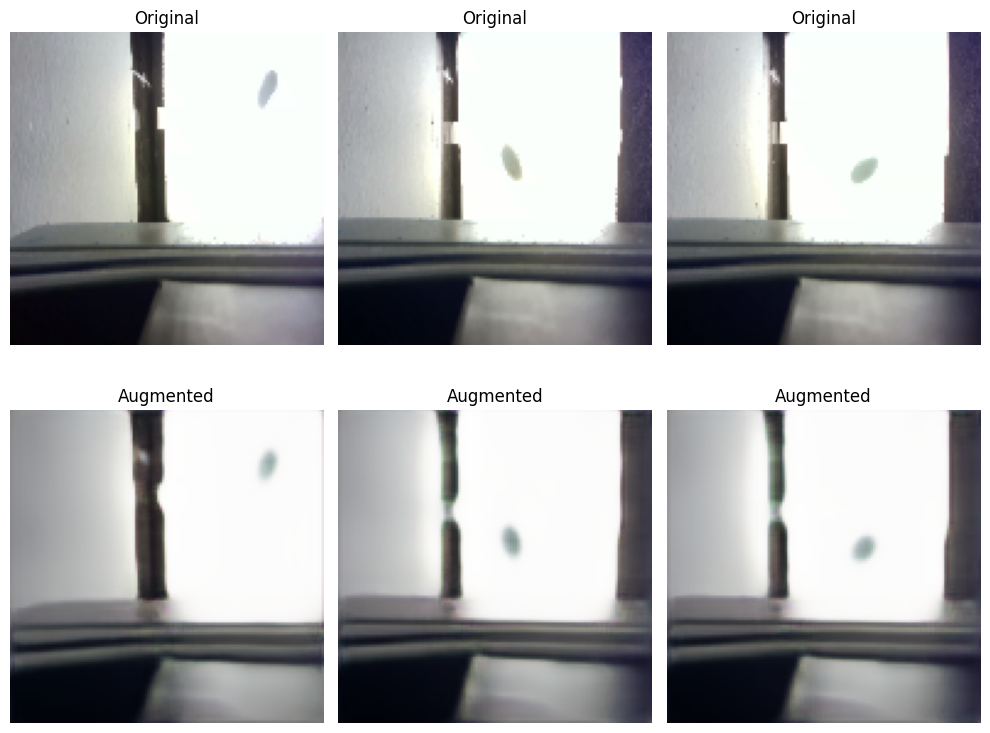

In [ ]:
#change archi from unet to std autoencoder
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil

# === CONFIGURATION (Standard AE Final Trial) ===
IMG_SIZE = 128
NOISE_STD_DEV = 0.12   # Max noise level
SSIM_WEIGHT = 0.75     # High SSIM weight
EPOCHS = 30
BATCH_SIZE = 16

# 🛠️ ADJUST THESE PATHS:
base_dir = "/content/tiget"
output_dir = "/content/gdrive/MyDrive/cae_aug_final" # New output folder for the final attempt
SOURCE_IMAGE_DIR = base_dir

os.makedirs(output_dir, exist_ok=True)

# === IMAGE LOADING AND DATA SPLIT (Unchanged) ===
def load_all_images_from_folder(folder):
    """Loads, resizes, and normalizes ALL images from a single folder."""
    imgs = []
    filenames = []
    if not os.path.exists(folder):
        print(f"Error: Source directory not found at {folder}")
        return np.array(imgs), filenames
    for filename in sorted(os.listdir(folder)):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img = cv2.imread(os.path.join(folder, filename))
            if img is None: continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype("float32") / 255.0
            imgs.append(img)
            filenames.append(filename)
    return np.array(imgs), filenames

print("Loading and preprocessing all data...")
all_imgs, all_names = load_all_images_from_folder(SOURCE_IMAGE_DIR)

if len(all_imgs) > 0:
    train_imgs, val_imgs, train_names, val_names = train_test_split(all_imgs, all_names, test_size=0.2, random_state=42)
    print(f"Total images loaded: {len(all_imgs)}")
    print(f"Train images split: {len(train_imgs)}, Validation images split: {len(val_imgs)}")
else:
    raise RuntimeError(f"FATAL ERROR: No images were loaded. Check if images exist in {SOURCE_IMAGE_DIR}")


# === STANDARD AUTOENCODER MODEL (SKIP CONNECTIONS REMOVED) ===
def build_sharp_cae():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # ENCODER
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp); p1 = layers.MaxPooling2D((2,2))(c1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1); p2 = layers.MaxPooling2D((2,2))(c2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2); p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    b = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p3)
    noisy_b = layers.GaussianNoise(NOISE_STD_DEV)(b)

    # DECODER (NO SKIP CONNECTIONS) 💣

    u3 = layers.UpSampling2D((2,2))(noisy_b)
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u3) # No Concatenate

    u2 = layers.UpSampling2D((2,2))(c4)
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u2) # No Concatenate

    u1 = layers.UpSampling2D((2,2))(c5)
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u1) # No Concatenate

    out = layers.Conv2D(3, (1,1), activation='sigmoid', padding='same')(c6)
    return models.Model(inp, out)

# === CUSTOM LOSS (Unchanged) ===
def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return (1.0 - SSIM_WEIGHT) * mse + SSIM_WEIGHT * ssim_loss

# === TRAIN (Unchanged) ===
sharp_cae = build_sharp_cae()
sharp_cae.compile(optimizer='adam', loss=combined_loss)

print("Starting CAE training...")
sharp_cae.fit(train_imgs, train_imgs, validation_data=(val_imgs, val_imgs), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

print("Generating augmented images and saving...")
for split, imgs, names in zip(["train", "val"], [train_imgs, val_imgs], [train_names, val_names]):
    out_dir = os.path.join(output_dir, split, "images")
    os.makedirs(out_dir, exist_ok=True)
    preds = sharp_cae.predict(imgs)
    for i, img in enumerate(preds):
        out_path = os.path.join(out_dir, f"cae_{names[i]}")
        cv2.imwrite(out_path, (img * 255).astype(np.uint8))

print(f"✅ CAE augmentation complete. Outputs saved to: {output_dir}")


# === SSIM CHECK (Unchanged) ===
avg_ssim_score = 0
count = 0
sample_size = min(len(train_imgs), 50)
sample_indices = np.random.choice(len(train_imgs), sample_size, replace=False)

for i in sample_indices:
    original_img = (train_imgs[i] * 255).astype(np.uint8)
    predicted_img = sharp_cae.predict(np.expand_dims(train_imgs[i], 0))[0]
    predicted_img = (predicted_img * 255).astype(np.uint8)

    original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    predicted_gray = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2GRAY)

    score, _ = ssim(original_gray, predicted_gray, full=True)
    avg_ssim_score += score
    count += 1

final_avg_ssim = avg_ssim_score / count
print(f"\n✨ Average SSIM between Original and Augmented Images (Sampled): {final_avg_ssim:.4f}")

if 0.8 <= final_avg_ssim <= 0.95:
    print("Augmentation quality looks GOOD! Ready to copy labels.")
else:
    print("SSIM value is still outside the ideal range (0.8 - 0.95). Proceeding with YOLO training is recommended.")


# === VISUALIZE 3 IMAGES SIDE BY SIDE (Unchanged) ===
num_display = min(3, len(train_imgs))
plt.figure(figsize=(10, 8))
for i in range(num_display):
    plt.subplot(2, num_display, i+1)
    plt.imshow((train_imgs[i]*255).astype(np.uint8)); plt.axis('off'); plt.title(f"Original")
    plt.subplot(2, num_display, i+1+num_display)
    aug_img_display = sharp_cae.predict(np.expand_dims(train_imgs[i],0))[0]
    plt.imshow((aug_img_display*255).astype(np.uint8)); plt.axis('off'); plt.title(f"Augmented")

plt.tight_layout()
plt.show()

Loading and preprocessing all data...
Total images loaded: 304
Starting CAE training...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 437ms/step - loss: 0.3416 - val_loss: 0.1840
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.1515 - val_loss: 0.0762
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0704 - val_loss: 0.0454
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0437 - val_loss: 0.0297
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0293 - val_loss: 0.0201
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0197 - val_loss: 0.0149
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0148 - val_loss: 0.0123
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0127 - val_loss: 0.0132
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0124 - val_loss: 0.0100
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0107 - val_loss: 0.0089
Epoch 11/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss:

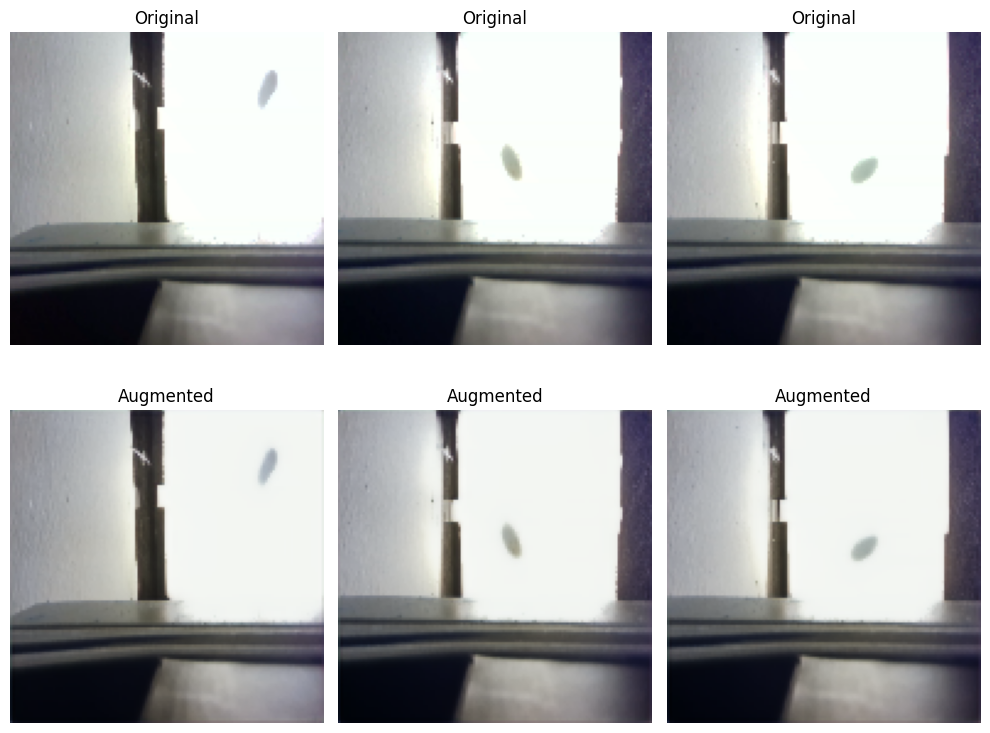

In [ ]:
#cae final noise_std = 0.07 ssim=0.75
#FINALLY USED THIS
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt

# === CONFIGURATION (Final Visually-Safe Setup) ===
IMG_SIZE = 128
# Reverting to controlled noise/loss for best visual quality
NOISE_STD_DEV = 0.07
SSIM_WEIGHT = 0.75
EPOCHS = 30
BATCH_SIZE = 16
NUM_DIGITS = 3 # For color_001.png format

# 🛠️ FINAL PATHS:
base_dir = "/content/tiget" # Directory containing all original color_xxx.png files and labels
output_dir = "/content/gdrive/MyDrive/cae_results" # Specified output folder
SOURCE_IMAGE_DIR = base_dir

os.makedirs(output_dir, exist_ok=True)

# === DATA LOADING (Unchanged) ===
def load_all_images_from_folder(folder):
    """Loads all color_xxx.png images and extracts filenames."""
    imgs = []
    filenames = []
    if not os.path.exists(folder): raise RuntimeError(f"Error: Source directory not found at {folder}")

    for filename in sorted(os.listdir(folder)):
        if filename.endswith(('.png')):
            img = cv2.imread(os.path.join(folder, filename))
            if img is None: continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype("float32") / 255.0
            imgs.append(img)
            filenames.append(os.path.splitext(filename)[0])
    return np.array(imgs), filenames

print("Loading and preprocessing all data...")
all_imgs, all_names = load_all_images_from_folder(SOURCE_IMAGE_DIR)

if len(all_imgs) == 0:
    raise RuntimeError(f"FATAL ERROR: No images were loaded.")

train_imgs, val_imgs, train_names, val_names = train_test_split(all_imgs, all_names, test_size=0.2, random_state=42)
print(f"Total images loaded: {len(all_imgs)}")


# === REFINED CAE MODEL (U-NET WITH WEAKENED SKIP CONNECTIONS) ===
def build_sharp_cae():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # ENCODER
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp); p1 = layers.MaxPooling2D((2,2))(c1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1); p2 = layers.MaxPooling2D((2,2))(c2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2); p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    b = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p3)
    noisy_b = layers.GaussianNoise(NOISE_STD_DEV)(b)

    # DECODER with WEAKENED skip connections (The best visual architecture)
    filtered_c3 = layers.Conv2D(128, (1, 1), activation='relu', padding='same')(c3)
    u3 = layers.UpSampling2D((2,2))(noisy_b); m3 = layers.Concatenate()([u3, filtered_c3])
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(m3)

    filtered_c2 = layers.Conv2D(64, (1, 1), activation='relu', padding='same')(c2)
    u2 = layers.UpSampling2D((2,2))(c4); m2 = layers.Concatenate()([u2, filtered_c2])
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(m2)

    filtered_c1 = layers.Conv2D(32, (1, 1), activation='relu', padding='same')(c1)
    u1 = layers.UpSampling2D((2,2))(c5); m1 = layers.Concatenate()([u1, filtered_c1])
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(m1)

    out = layers.Conv2D(3, (1,1), activation='sigmoid', padding='same')(c6)
    return models.Model(inp, out)

# === CUSTOM LOSS / TRAIN (Using 0.75 SSIM_WEIGHT) ===
def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return (1.0 - SSIM_WEIGHT) * mse + SSIM_WEIGHT * ssim_loss

sharp_cae = build_sharp_cae()
sharp_cae.compile(optimizer='adam', loss=combined_loss)

print("Starting CAE training...")
sharp_cae.fit(train_imgs, train_imgs, validation_data=(val_imgs, val_imgs), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

# === GENERATE AND SAVE OUTPUTS WITH CONTINUOUS NUMBERING (CRITICAL) ===
print("Generating augmented images and saving with sequential numbering...")

start_index = len(all_imgs) + 1 # Starts at 306 if 305 original images
current_index = start_index

out_dir_images = os.path.join(output_dir, "images")
out_dir_labels = os.path.join(output_dir, "labels")
os.makedirs(out_dir_images, exist_ok=True)
os.makedirs(out_dir_labels, exist_ok=True)

# Process both train and val splits sequentially
for imgs, names in [(train_imgs, train_names), (val_imgs, val_names)]:
    preds = sharp_cae.predict(imgs)
    for i, img in enumerate(preds):
        # 1. New File Name (e.g., color_306)
        new_name_base = f"color_{current_index:0{NUM_DIGITS}d}"

        # 2. Save Augmented Image
        out_path_img = os.path.join(out_dir_images, f"{new_name_base}.png")
        cv2.imwrite(out_path_img, (img * 255).astype(np.uint8))

        # 3. Copy Original Label to New Name
        original_base_name = names[i] # e.g., 'color_001'
        original_label_path = os.path.join(base_dir, f"{original_base_name}.txt") # Assumes color_001.txt is in /content/tiget/

        out_path_label = os.path.join(out_dir_labels, f"{new_name_base}.txt")

        if os.path.exists(original_label_path):
            shutil.copyfile(original_label_path, out_path_label)
        else:
            print(f"Warning: Original label not found for {original_base_name}.txt. Cannot create augmented label {new_name_base}.txt")

        current_index += 1

print(f"✅ CAE augmentation complete. Augmented images and labels saved sequentially to: {output_dir}")


# === SSIM CHECK (For Reference) ===
avg_ssim_score = 0
count = 0
sample_size = min(len(train_imgs), 50)
sample_indices = np.random.choice(len(train_imgs), sample_size, replace=False)

for i in sample_indices:
    original_img = (train_imgs[i] * 255).astype(np.uint8)
    predicted_img = sharp_cae.predict(np.expand_dims(train_imgs[i], 0))[0]
    predicted_img = (predicted_img * 255).astype(np.uint8)
    original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    predicted_gray = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2GRAY)
    score, _ = ssim(original_gray, predicted_gray, full=True)
    avg_ssim_score += score
    count += 1

final_avg_ssim = avg_ssim_score / count
print(f"\n✨ Average SSIM between Original and Augmented Images (Sampled): {final_avg_ssim:.4f}")

if final_avg_ssim < 0.98:
    print("SSIM below 0.98, suggesting structural variation. You are now ready for YOLO training! 🚀")
else:
    print("SSIM is still very high. Be aware the augmentation effect may be subtle.")


# === VISUALIZE 3 IMAGES SIDE BY SIDE (For Visual Check) ===
num_display = min(3, len(train_imgs))
plt.figure(figsize=(10, 8))
for i in range(num_display):
    plt.subplot(2, num_display, i+1)
    plt.imshow((train_imgs[i]*255).astype(np.uint8)); plt.axis('off'); plt.title(f"Original")
    plt.subplot(2, num_display, i+1+num_display)
    aug_img_display = sharp_cae.predict(np.expand_dims(train_imgs[i],0))[0]
    plt.imshow((aug_img_display*255).astype(np.uint8)); plt.axis('off'); plt.title(f"Augmented")

plt.tight_layout()
plt.show()